Initial Preprocessing

In [1]:
print("Versions")

import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")


import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.colors import Color


sns.set_style('whitegrid')


import scattertext as st


import re
print(f're: {re.__version__}')


import spacy
print(f'spaCy: {spacy.__version__}')
import nltk
print(f'nltk: {nltk.__version__}')
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import yaml

from spacymoji import Emoji

from collections import Counter


from tqdm.notebook import tqdm
tqdm().pandas() 

Versions
Pandas: 1.4.1
Numpy: 1.22.3
re: 2.2.1
spaCy: 3.2.4
nltk: 3.7


0it [00:00, ?it/s]

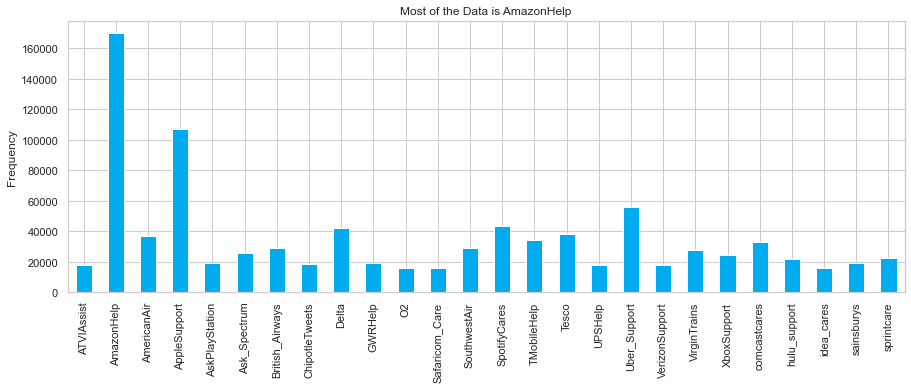

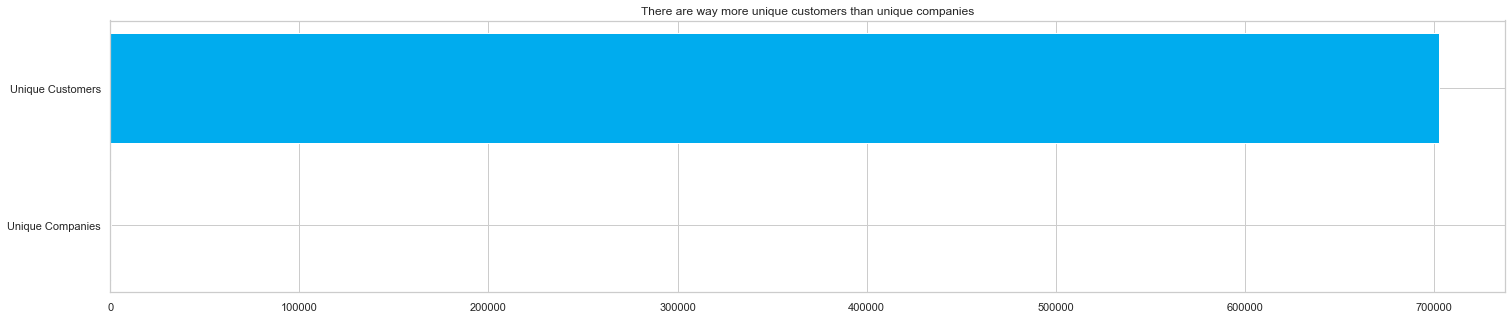

CPU times: total: 12.8 s
Wall time: 16.6 s


In [2]:

all_data = pd.read_csv('data/twcs/twcs.csv')


count = all_data.groupby("author_id")["text"].count()

c = count[count>15000].plot(kind='bar',figsize=(15, 5), color='#00acee')
c.set_xlabel('')
c.set_ylabel('Frequency')
plt.title('Most of the Data is AmazonHelp')

plt.savefig('visualizations/authors.png')

plt.show()

authors_count = (len(all_data[all_data.inbound == False].author_id.unique()), len(all_data[all_data.inbound == True].author_id.unique()))

plt.figure(figsize =(25,5))
x = ['Unique Companies','Unique Customers']
ax = plt.barh(x, authors_count, color = '#00acee')
plt.title('There are way more unique customers than unique companies')
plt.show()


In [3]:

print('All data has shape {}'.format(all_data.shape))


all_data['text'] = all_data['text'].astype('string')
all_data['author_id'] = all_data['author_id'].astype('string')

show = lambda x: x.head(5).style.set_properties(**{'background-color': 'black',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'cyan'}")\
.background_gradient(cmap='Blues')

show(all_data)

All data has shape (2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,0,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.000000
1,2,115712,1,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,nan,1.000000
2,3,115712,1,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.000000
3,4,sprintcare,0,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.000000
4,5,115712,1,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.000000


In [4]:
apple_data = all_data[all_data['author_id'] == 'AppleSupport']
apple_data.shape

(106860, 7)

In [5]:
apple_data.dropna(subset = ['in_response_to_tweet_id'],inplace = True)
apple_data['inbound'].value_counts(), apple_data.shape

(False    106719
 Name: inbound, dtype: int64,
 (106719, 7))

In [6]:

apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')


apple_data = pd.merge(all_data[['tweet_id','text']],apple_data,left_on='tweet_id', right_on='in_response_to_tweet_id')


apple_data.drop(['tweet_id_x','tweet_id_y','in_response_to_tweet_id','inbound'], axis = 1, inplace = True)


apple_data.rename(columns = {'text_x':'inbound_text','text_y':'outbound_text'},inplace = True)


text = apple_data[['inbound_text','outbound_text']]


print(text.head())


text.to_pickle('objects/raw_text.pkl')

inbound = text['inbound_text']
outbound = text['outbound_text']


                                        inbound_text  \
0  @AppleSupport The newest update. I️ made sure ...   
1             @AppleSupport  https://t.co/NV0yucs0lB   
2  @AppleSupport Tried resetting my settings .. r...   
3  @AppleSupport This is what it looks like https...   
4  @AppleSupport I️ have an iPhone 7 Plus and yes...   

                                       outbound_text  
0  @115854 Lets take a closer look into this issu...  
1  @115854 We're here for you. Which version of t...  
2  @115855 Let's go to DM for the next steps. DM ...  
3  @115855 Any steps tried since it started last ...  
4  @115855 That's great it has iOS 11.1 as we can...  


In [7]:
show(apple_data)

,inbound_text,author_id,created_at,outbound_text,response_tweet_id
0,@AppleSupport The newest update. I️ made sure to download it yesterday.,AppleSupport,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issue. Select the following link to join us in a DM and we'll go from there. https://t.co/GDrqU22YpT,nan
1,@AppleSupport https://t.co/NV0yucs0lB,AppleSupport,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of the iOS are you running? Check from Settings > General > About.,697
2,@AppleSupport Tried resetting my settings .. restarting my phone .. all that,AppleSupport,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM us here: https://t.co/GDrqU22YpT,nan
3,@AppleSupport This is what it looks like https://t.co/XCQU2l4xUB,AppleSupport,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last night?,702
4,@AppleSupport I️ have an iPhone 7 Plus and yes I️ do,AppleSupport,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can rule out being outdated. Any steps tried since this started? Do you recall when it started?,"706,704"


In [8]:


def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    inbound = bagofwords.fit_transform(data)
    inbound
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names_out())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)

    words_rank.head()

    plt.figure(figsize=(12,6))
  
   
    sns.barplot(x=words_rank['word'][:10], y=words_rank['count'][:10], palette = 'inferno')
    plt.title(title)
    
 
    plt.savefig(f'visualizations/{output_name}.png')
    
    plt.show()

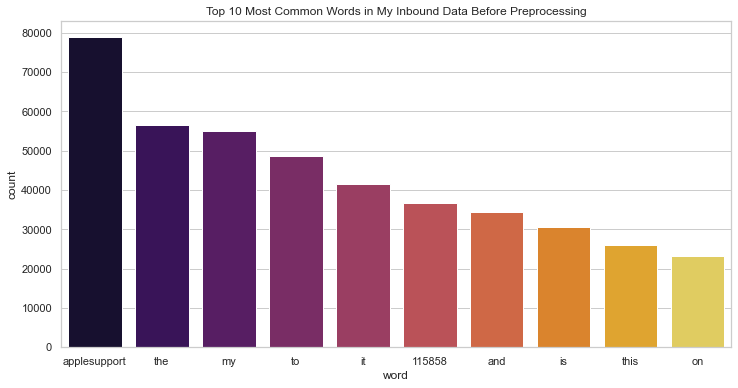

In [9]:
top10_bagofwords(inbound, 'most_common_before' ,'Top 10 Most Common Words in My Inbound Data Before Preprocessing')

In [10]:

nlp = spacy.load('en_core_web_sm')
emoji = Emoji(nlp, merge_spans=False)
nlp.add_pipe("emoji", first=True)
print(nlp.pipe_names)


emojis = []
for doc in tqdm(nlp.pipe(inbound, batch_size=512)):
    if doc._.has_emoji:
        for e in doc._.emoji:
            emojis.extend(e[0])


emoji_count = Counter(emojis)
emoji_count.most_common(30)

['emoji', 'tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


0it [00:00, ?it/s]

[('😡', 3069),
 ('️', 1516),
 ('🙄', 1463),
 ('😭', 1100),
 ('\u200d', 1000),
 ('🤔', 959),
 ('😒', 830),
 ('😤', 780),
 ('🤬', 750),
 ('😩', 699),
 ('🏻', 694),
 ('🤦', 622),
 ('🙃', 549),
 ('♀', 537),
 ('🏼', 535),
 ('🏽', 487),
 ('♂', 454),
 ('😑', 438),
 ('😂', 365),
 ('🏾', 337),
 ('🤷', 321),
 ('👎', 315),
 ('👍', 280),
 ('😫', 269),
 ('😐', 261),
 ('😠', 252),
 ('📱', 236),
 ('☹', 226),
 ('🙏', 196),
 ('😔', 194)]

In [11]:

unique_emojis = [i[0] for i in emoji_count]


plotted_emojis = [i[0] for i in emoji_count.most_common(30)]
plotted_emojis = plotted_emojis[:3] + plotted_emojis[5:]
counts = [i[1] for i in emoji_count.most_common(30)]
counts = counts[:3] + counts[5:]



output_file("visualizations/emojis.html")


p = figure(x_range=plotted_emojis, plot_height=600, plot_width = 1300, title="Emoji Counts",
           toolbar_location=None, tools="")
p.vbar(x=plotted_emojis, top=counts, width=0.9, color = "#FBD043")
p.xgrid.grid_line_color = None
p.y_range.start = 0


In [12]:
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
import spacy_fastlang
def get_lang_detector(nlp, name):
    return LanguageDetector()

punct_base = ['?']


puncts = ['\u200d','?', '....','..','...','','@','#', ',', '.', '"', ':', ')', '(', '-', '!', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '*', '+', '\\', 
    '•', '~', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
    '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
    '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 
    'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', 
    '¹', '≤', '‡', '√', '!','🅰','🅱']


stopwords.words('english');
stop_words = set(stopwords.words('english')) 


contraction_colloq_dict = {"btw": "by the way", "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have"}


lemmatizer = nltk.stem.WordNetLemmatizer()

import emoji 


try:
    
    nlp_cld = spacy.load('en_core_web_sm',disable=["tagger","ner","lemmatizer"])
    nlp_cld.add_pipe("language_detector")
except ValueError as e:
    print("The spaCy function was run more than once, but that's okay because it means it was initialized!")

## My Entire Preliminary Text Preprocessing Pipeline



In [13]:
def visualize_lengths(data,title):
    
    lengths = [len(i) for i in data]
    plt.figure(figsize=(13,6))
    plt.hist(lengths, bins = 40)
    plt.title(title)
    plt.show()
    
def remove_from_list(x, stuff_to_remove) -> list:
        
        for item in stuff_to_remove:
           
            for i,token in enumerate(x):
                if item == token:
                    del x[i]
        return x
    
def remove_links(doc):
    return [re.sub(r'^https?:\/\/.*[\r\n]*', '', token, flags=re.MULTILINE) for token in doc]

def correct_spellings(x):
    
    corrected_text = []
    for word in x:
        if word in x:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return corrected_text

def replace_from_dict(x,dic):

    replaced_counter = 0
    for item in dic.items():
        for i, e in enumerate(x):
            if e == item[0]:
                replaced_counter+=1
                    
                del x[i]
                for ix, token in enumerate(item[1].split()):
                    x.insert(i+ix,token)

    return x    

def only_english(x):

    mask = []
    x = x.apply(" ".join)
    try:
        for i,doc in tqdm(enumerate(nlp_cld.pipe(x, batch_size=512))):
            
            if 'en' not in doc._.language or len(doc._.language) < 1:
                mask.append(False)
            else:
                mask.append(True)
    except Exception as e:
        print(f"Exception:{e}")
    return mask

def get_wordnet_pos(word):
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def lemmatize_list(x):
    

    x = " ".join(x)
    
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)]

def extract_emojis(s):
        return [c for c in s if c not in emoji.UNICODE_EMOJI]

def limit_length(x, max_tokens, min_tokens):

    output = x
    if len(x) > max_tokens:
        output = np.nan
    if len(x) <= min_tokens:
        output = np.nan
    return output

def clean_numbers(x):
    for i,j in enumerate(x):
        if bool(re.search(r'\d', j)):
            del x[i]
    return x

def validate(func, locals):
    
    for var, test in func.__annotations__.items():
        value = locals[var]
        try: 
            pr=test.__name__+': '+test.__docstring__
        except AttributeError:
            pr=test.__name__   
        msg = '{}=={}; Test: {}'.format(var, value, pr)
        assert test(value), msg



def my_tokenizer(data: lambda _data: isinstance(_data, pd.Series)):

    
    
    assert isinstance(data,pd.Series), 'Input must be a Pandas Series'

    
    
    data = data.str.lower()
    
    print(f'1. Original shape of data is {data.shape}')
    
    

    tknzr = TweetTokenizer(strip_handles = True, reduce_len = True)
    
    data = data.progress_apply(tknzr.tokenize)
    
    print(f'2. Tokenized, removed handles, and reduced the length of repeated characters.\
          \n Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 2')
    
    
    
    data = data.progress_apply(remove_from_list, stuff_to_remove = puncts)
    print(f'3. Removed empty tokens and punctuation. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 9')
    
    
    
    data = data.progress_apply(remove_links)
    
    print(f'3. Removed the links. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 3')

    
    spell = SpellChecker()
    

    
    print(f'4. Applied automispelling corrections. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    
    
    
    
    data = data.progress_apply(remove_from_list, stuff_to_remove = stop_words)
    
    print(f'5. Removed the stop words. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 4')
    
   
    
    data = data.progress_apply(replace_from_dict, dic = contraction_colloq_dict)
    print(f'6. Expanded contractions into extra tokens. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 5')
    

    data = data[only_english(data)]
    print(f'7. Remove all non-english Tweets. Shape is now {data.shape}. Clearly less than before! \n \n Peek: \n {data.head()}')
    
 

    data = data.progress_apply(lemmatize_list)
    print(f'8. Lemmatized the tokens. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 8')   
   

    data = data.progress_apply(remove_from_list, stuff_to_remove = puncts)


    
    unique_emojis = [i[0] for i in emoji.UNICODE_EMOJI]
    data = data.apply(remove_from_list, stuff_to_remove = unique_emojis)
    

    data = data.progress_apply(clean_numbers)
    
    print(f'9. Removed emojis and numbers. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 9')   
    

    max_tokens = 50
    min_tokens = 5
    data = data.progress_apply(limit_length, min_tokens = min_tokens, max_tokens = max_tokens)

    data = data.dropna()
    print(f'10. Limited each tweet to a max of {max_tokens} tokens and a min of {min_tokens} tokens. Shape is now {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 10')
    
    return data
    

1. Original shape of data is (106648,)


  0%|          | 0/106648 [00:00<?, ?it/s]

2. Tokenized, removed handles, and reduced the length of repeated characters.          
 Shape is still (106648,). 
 
 Peek: 
 0    [the, newest, update, ., i️, made, sure, to, d...
1                            [https://t.co/nv0yucs0lb]
2    [tried, resetting, my, settings, .., restartin...
3    [this, is, what, it, looks, like, https://t.co...
4    [i️, have, an, iphone, 7, plus, and, yes, i️, do]
Name: inbound_text, dtype: object


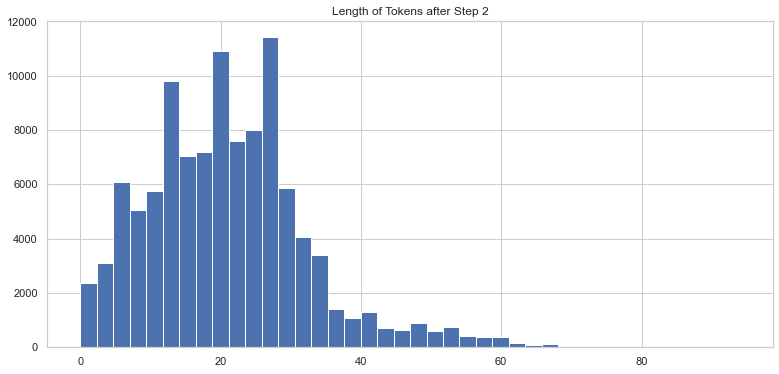

  0%|          | 0/106648 [00:00<?, ?it/s]

3. Removed empty tokens and punctuation. Shape is still (106648,). 
 
 Peek: 
 0    [the, newest, update, i️, made, sure, to, down...
1                            [https://t.co/nv0yucs0lb]
2    [tried, resetting, my, settings, restarting, m...
3    [this, is, what, it, looks, like, https://t.co...
4    [i️, have, an, iphone, 7, plus, and, yes, i️, do]
Name: inbound_text, dtype: object


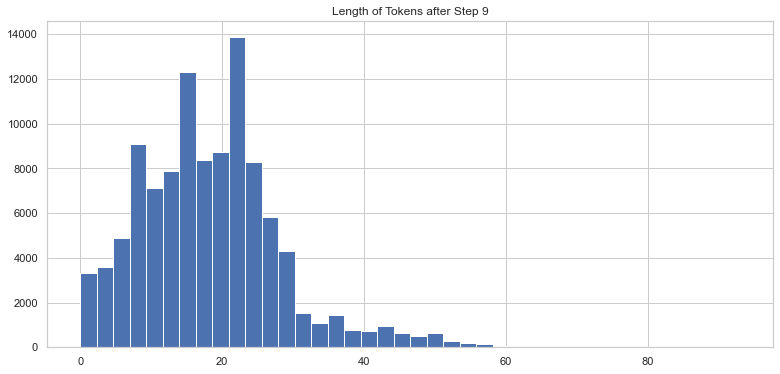

  0%|          | 0/106648 [00:00<?, ?it/s]

3. Removed the links. Shape is still (106648,). 
 
 Peek: 
 0    [the, newest, update, i️, made, sure, to, down...
1                                                   []
2    [tried, resetting, my, settings, restarting, m...
3                  [this, is, what, it, looks, like, ]
4    [i️, have, an, iphone, 7, plus, and, yes, i️, do]
Name: inbound_text, dtype: object


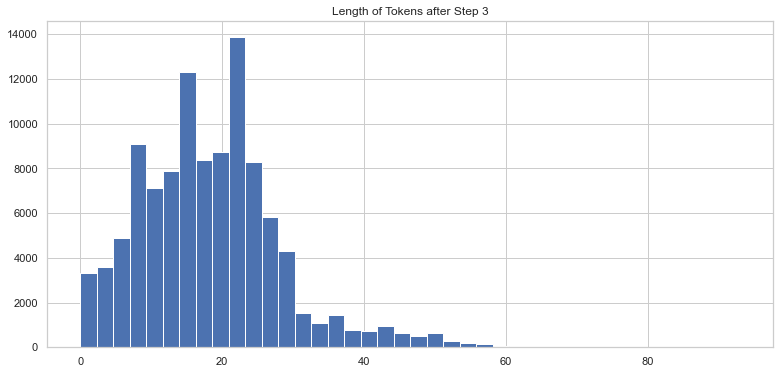

4. Applied automispelling corrections. Shape is still (106648,). 
 
 Peek: 
 0    [the, newest, update, i️, made, sure, to, down...
1                                                   []
2    [tried, resetting, my, settings, restarting, m...
3                  [this, is, what, it, looks, like, ]
4    [i️, have, an, iphone, 7, plus, and, yes, i️, do]
Name: inbound_text, dtype: object


  0%|          | 0/106648 [00:00<?, ?it/s]

5. Removed the stop words. Shape is still (106648,). 
 
 Peek: 
 0    [newest, update, i️, made, sure, download, yes...
1                                                   []
2      [tried, resetting, settings, restarting, phone]
3                                      [looks, like, ]
4                       [i️, iphone, 7, plus, yes, i️]
Name: inbound_text, dtype: object


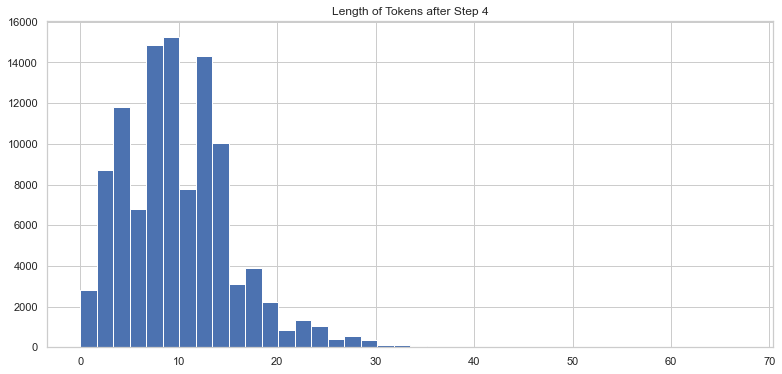

  0%|          | 0/106648 [00:00<?, ?it/s]

6. Expanded contractions into extra tokens. Shape is still (106648,). 
 
 Peek: 
 0    [newest, update, i️, made, sure, download, yes...
1                                                   []
2      [tried, resetting, settings, restarting, phone]
3                                      [looks, like, ]
4                       [i️, iphone, 7, plus, yes, i️]
Name: inbound_text, dtype: object


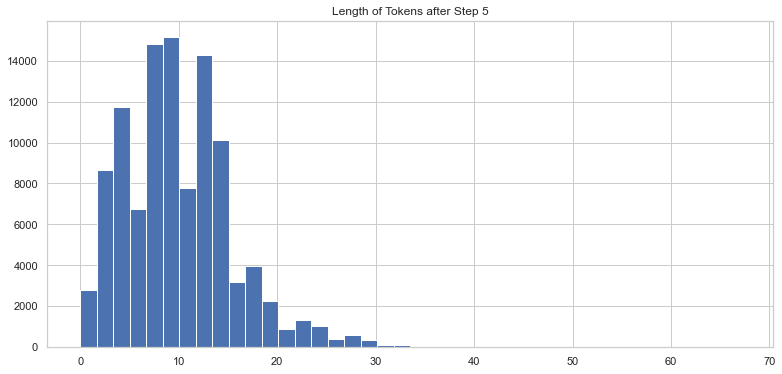

0it [00:00, ?it/s]

7. Remove all non-english Tweets. Shape is now (101396,). Clearly less than before! 
 
 Peek: 
 0    [newest, update, i️, made, sure, download, yes...
1                                                   []
2      [tried, resetting, settings, restarting, phone]
3                                      [looks, like, ]
5                     [i️, need, answers, annoying, 🙃]
Name: inbound_text, dtype: object


  0%|          | 0/101396 [00:00<?, ?it/s]

8. Lemmatized the tokens. Shape is still (101396,). 
 
 Peek: 
 0    [new, update, i️, make, sure, download, yester...
1                                                   []
2                [try, reset, setting, restart, phone]
3                                         [look, like]
5                         [i️, need, answer, annoy, 🙃]
Name: inbound_text, dtype: object


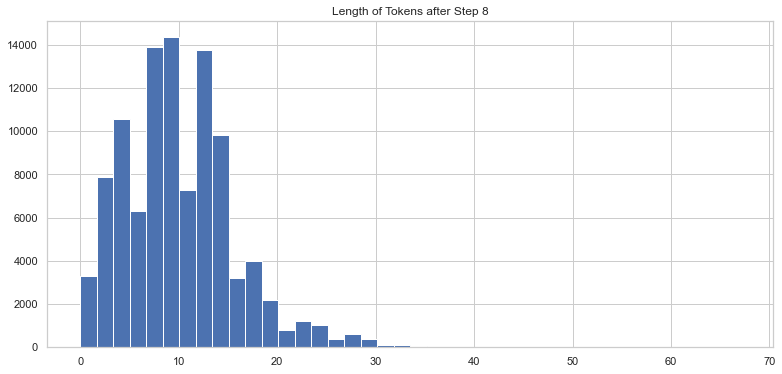

  0%|          | 0/101396 [00:00<?, ?it/s]

  0%|          | 0/101396 [00:00<?, ?it/s]

9. Removed emojis and numbers. Shape is still (101396,). 
 
 Peek: 
 0    [new, update, i️, make, sure, download, yester...
1                                                   []
2                [try, reset, setting, restart, phone]
3                                         [look, like]
5                            [i️, need, answer, annoy]
Name: inbound_text, dtype: object


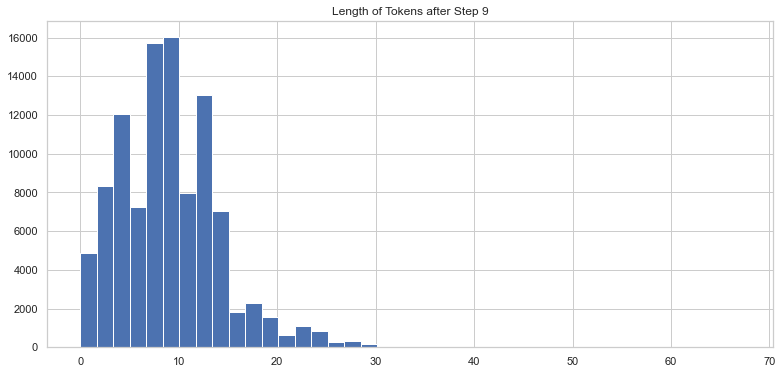

  0%|          | 0/101396 [00:00<?, ?it/s]

10. Limited each tweet to a max of 50 tokens and a min of 5 tokens. Shape is now (76068,). 
 
 Peek: 
 0     [new, update, i️, make, sure, download, yester...
6     [hey, anyone, else, upgraded, io, issue, capit...
12    [hello, internet, someone, explain, symbol, ke...
13    [get, screenshot, say, iphonex, reserve, email...
15    [thank, update, phone, even, slow, barely, wor...
Name: inbound_text, dtype: object


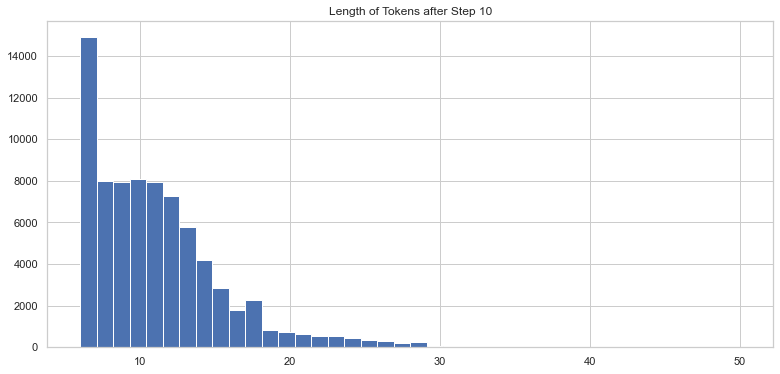

In [14]:
processed_inbound = my_tokenizer(text['inbound_text'])


This is great, we now have the preprocessed data stored into the variable ```processed_inbound```. Now let's convert this processed data to pkl so that I don't have to run this over and over again to use at the next notebook.

In [15]:
processed_inbound.tail()

106643    [anyone, issue, osx, highsierra, slack, zoom, ...
106644    [hey, able, duplicate, file, page, search, rea...
106645    [yo, weird, glitch, w, capital, i️, attempt, m...
106646    [fuck, phone, keep, hang, call, show, call, fa...
106647    [anyone, iphone, issue, phone, freeze, randoml...
Name: inbound_text, dtype: object

In [16]:
processed_inbound

0         [new, update, i️, make, sure, download, yester...
6         [hey, anyone, else, upgraded, io, issue, capit...
12        [hello, internet, someone, explain, symbol, ke...
13        [get, screenshot, say, iphonex, reserve, email...
15        [thank, update, phone, even, slow, barely, wor...
                                ...                        
106643    [anyone, issue, osx, highsierra, slack, zoom, ...
106644    [hey, able, duplicate, file, page, search, rea...
106645    [yo, weird, glitch, w, capital, i️, attempt, m...
106646    [fuck, phone, keep, hang, call, show, call, fa...
106647    [anyone, iphone, issue, phone, freeze, randoml...
Name: inbound_text, Length: 76068, dtype: object

In [17]:
real_inbound = text['inbound_text'].loc[processed_inbound.index]
real_outbound = text['outbound_text'].loc[processed_inbound.index]
processed_inbound


processed = pd.DataFrame({'Processed Inbound': processed_inbound, 'Real Inbound': real_inbound,
             'Real Outbound': real_outbound})

processed.head()

,Processed Inbound,Real Inbound,Real Outbound
0,"[new, update, i️, make, sure, download, yester...",@AppleSupport The newest update. I️ made sure ...,@115854 Lets take a closer look into this issu...
6,"[hey, anyone, else, upgraded, io, issue, capit...",Hey @AppleSupport and anyone else who upgraded...,"@115856 Hey, let's work together to figure out..."
12,"[hello, internet, someone, explain, symbol, ke...","Hello, internet. Can someone explain why this ...",@115861 You're in the right place; we'll do al...
13,"[get, screenshot, say, iphonex, reserve, email...",@AppleSupport I’ve got a screenshot saying my ...,@115863 Go ahead and send us a DM please. Let ...
15,"[thank, update, phone, even, slow, barely, wor...",Thank you @AppleSupport I updated my phone and...,"@115864 We'd like to help, but we'll need more..."


In [18]:

processed_inbound.to_pickle('objects/processed_inbound.pkl')


processed.to_pickle('objects/processed.pkl')

In [19]:
processed_inbound = pd.read_pickle('objects/processed_inbound.pkl')
processed_inbound.head()

0     [new, update, i️, make, sure, download, yester...
6     [hey, anyone, else, upgraded, io, issue, capit...
12    [hello, internet, someone, explain, symbol, ke...
13    [get, screenshot, say, iphonex, reserve, email...
15    [thank, update, phone, even, slow, barely, wor...
Name: inbound_text, dtype: object